# Forecasting on Contraceptive Use - A Multi-step Ensemble Approach¶

Update: 09/07/2020

## key idea

- The goal is to forecast on site_code & product_code level demand.
- The site_code & product_code level demand fluctuates too much and doesn't have any obvious pattern. 
- The aggregate level is easier to forecast. The noise cancels out.
- We don't know what is the best level to aggregate. It's possible that it varies regarding each site too.
- we aggregate on various levels, and use "Ensemble Learning" to to determine the final result

## Aggregate  
How to aggregate? Here is the structure of the supply chain and products. We can use this guide our aggregation: 
- site_code -> district -> region
- product_code -> product_type
After we aggregate on some level, we get a time series of stock_distributed, {Y}.
We supplement some external data and match/aggregate to the same level, {X}.
we use a time-series model to forecast {Y} with {Y} and {X}.

## Forecast the Aggregate : Time Series Modeling, Auto_SARIMAX
- We use a SARIMAX stucture (ARIMA (AR, MA with a trend) with Seasonality and external data )
- The specific order of SARIMAX is determined within each time series.
- Use BIC criteria to pick the optimal order for ARIMA (p, d, q) and seasonality (P,D,Q) (BIC : best for forecast power) (range of p,d,q and P,D,Q - small, less than 4)
- use the time series model to make aggregate forecast

## De-aggregate (Distribute) : Machine Learning Modeling

- We use machine learning to learn the variable "share", the share of the specific stock_distributed as a fraction of the aggregate sum.
- training data:
    - all the data, excluding the last 3 month. Encode the year, month, region, district, product type, code, plus all available external data, matched to site_code+product level.
- target: actual shares 
- model: RandomForest Decision Regression Tree
    - use the fitted model to make prediction on shares. "Distribute" aggregate stocks to individual forecasts.
    
## Emsemble

perform twosteps model on different aggregating levels and generating different forecasts
build another layer to model the decision to make the final prediction
From Aggregate and Distribute, we arrive at X different forecast numbers for each site+product_code. (We also have a lot of intermediary forecasts that could be of interests to various parties).  
We introduce another model to perform the ensemble
For each training observation, we have multiple fourcasts and one actual realization, denote them as F1, F2, F3, F4 and Y (ommitting site, product, t time subscripts). We also have all the features X ( temperature, roads, etc).
The emsemble part estimate another model to take inputs (F1..F4, and features X) to arrive at an estimated Y_hat that minimizes its MSE to Y ( actual stock_distributed).

## Key Takeaway of this approach
- Combines traditional forecast methods and Machine Learning
- It's very transferable to other scenarios
- It uses external data and it's easy to plug in more external data.
- The ensemble piece makes adding model possible.

In [1]:
# suppress warning to make cleaner output 
import warnings
warnings.filterwarnings("ignore")

# Outline 
## Step 1: Data Cleaning 
### Upsample (fill in gaps in time series)
- notebook: datacleaning_upsample.ipynb  

In [2]:
%run   datacleaning_upsample.ipynb 

- inputs:  "..\0_data\contraceptive_logistics_data.csv"
- output:  "..\2_pipeline\df_upsample.csv"
- steps: 
    - upsample - make sure all individual product-site series has no gaps in time even though they may differ in length 
    - fill in 0 for NA in stock_distributed

### Supplement 
(very import thing about supplement data - if we are to use any supplement data, the value should exist for the 3 months that are to be forecasted) ( 10, 11, 12) Must be careful when constructing supplement dataset
- notebook: datacleaning_prep_supplement.ipynb

- input:
    - "..\0_data\supplement_data_raw.csv"
- steps:
    - time invariant supplement data:
        - identifiers: site_code product_code region district
        - information: (currently) road condition, product type
     - output: "../0_data/time_invariant_supplement.dta"

    - time variant supplement data: (include rows for time that need to be forecasted)
        - identifiers: temp_timeindex year month site_code product_code region district
        - information: maxtemp temp pressure relative rain visibility windspeed maxsus* storm fog
    - output: "../0_data/time_variant_supplement.dta"

### Combine 

- notebook: datacleaning_combine.ipynb 

In [3]:
%run datacleaning_combine.ipynb

import df_upsample from datacleaning_upsample.ipynb step
              year         month  stock_distributed
count  41348.00000  41348.000000       41348.000000
mean    2017.52225      6.305964          14.033399
std        1.06620      3.328858          39.523746
min     2016.00000      1.000000           0.000000
25%     2017.00000      3.000000           0.000000
50%     2018.00000      6.000000           0.000000
75%     2018.00000      9.000000          12.000000
max     2019.00000     12.000000        1805.000000

 prepare submission data site_code, product_code and time identifiers 

   year  month site_code product_code  predicted_value
0  2019     10     C4001      AS27134                0
1  2019     10     C4001      AS27132                0
2  2019     10     C4001      AS27000                0
3  2019     10     C4001      AS27137                0
4  2019     10     C4001      AS27138                0

 import time_invariant_supplement.dta from datacleaning_prep_supplement

- input: 
    - "../2_pipeline/df_upsample.csv"
    - '../0_data/submission_format.csv' 
    - "../0_data/time_invariant_supplement.dta" 
    - "../0_data/time_variant_supplement.dta"
    - '../0_data/service_delivery_site_data.csv' 
    
- output: a site_code & product_code & date level logistics data with time variant and time invariant exogenous features :
    - for development: '../0_data/df_training.csv'
    - for final prediction(contained 3 last month exog vars and space holder) '../0_data/df_combined_fullsample.csv'

## Step 2: Multiple Agg-Forecast-Distribute Models in parallel 

- notebook: model_SARIMAX_Distribute_region.ipynb 

%run model_SARIMAX_Distribute_region.ipynb 

    - input: 
        - '../0_data/df_combined_fullsample.csv' 
    - output:
        1. ../2_pipeline/final_pred_region_lev.csv
        2. ./2_pipeline/final_distribute_regionlev.csv'
        

- notebook: model_SARIMAX_Distribute_District.ipynb

AGBOVILLE
AS27138
(0, 0, 0)
(0, 0, 0, 12)


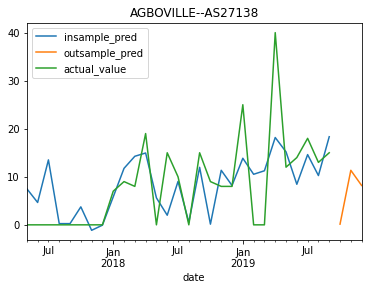

AGBOVILLE
AS27139
AGNIBILEKROU
AS27137
(0, 0, 0)
(0, 0, 0, 12)


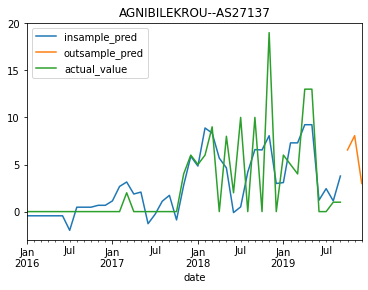

AGNIBILEKROU
AS27138


In [5]:
%run model_SARIMAX_Distribute_District.ipynb

     - input: 
          - '../0_data/df_combined_fullsample.csv' 
     - output::
        1. '../2_pipeline/final_pred_district_lev.csv'
        2. '../2_pipeline/final_distribute_districtlev.csv'


        
- notebook: model_SARIMAX_Distribute_regionproducttype.ipynb

GBEKE
Oral Contraceptive (Pill)
(1, 0, 0)
(0, 0, 1, 12)


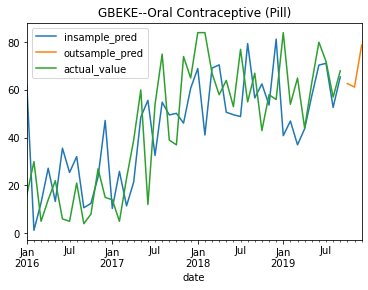

GBOKLE-NAWA-SAN PEDRO
Oral Contraceptive (Pill)
(1, 0, 0)
(1, 0, 0, 12)


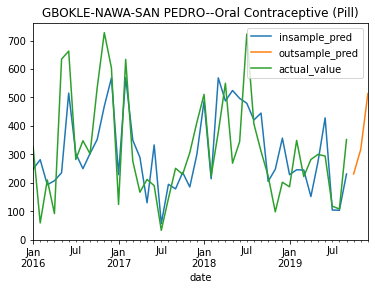

In [6]:
%run model_SARIMAX_Distribute_regionproducttype.ipynb

     - input: 
          - '../0_data/df_combined_fullsample.csv'
     - output: 
        1. ../2_pipeline/final_pred_region_producttype_lev.csv
        2. '../2_pipeline/final_distribute_regionproducttypelev.csv'

        
- notebook: model_SARIMAX_individual.ipyn

C1054
AS27138
(2, 0, 0)
(0, 0, 0, 12)


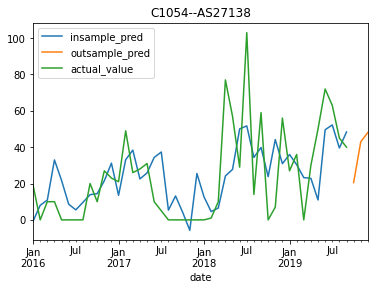

C1054
AS42018
C1059
AS27138
(0, 0, 0)
(0, 0, 0, 12)


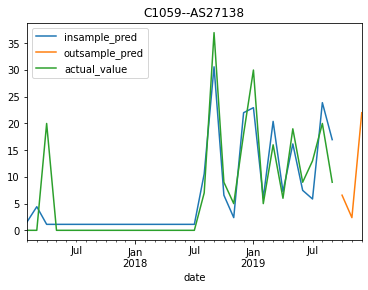

C1059
AS42018
(0, 0, 0)
(0, 0, 0, 0)
error


In [7]:
%run model_SARIMAX_individual.ipynb 

     - input: 
        - '../0_data/df_combined_fullsample.csv'
     - output: 
        - '../2_pipeline/final_pred_ind_lev.csv'

- notebook: model_SARIMAX_individual_winsorized.ipynb

C1054
AS27138
(1, 0, 0)
(0, 0, 0, 12)


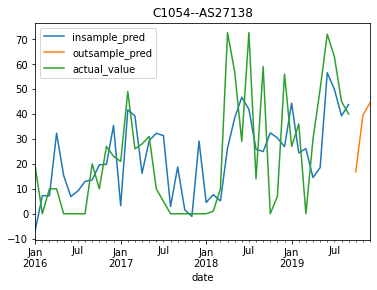

C1054
AS42018
C1059
AS27138
(1, 0, 0)
(0, 0, 0, 12)


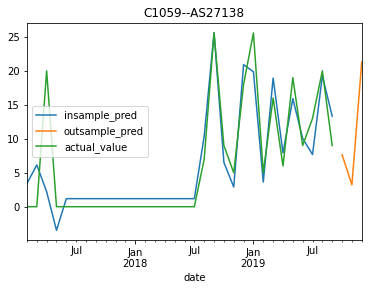

C1059
AS42018
(0, 0, 0)
(0, 0, 0, 0)
error


In [8]:
%run model_SARIMAX_individual_winsorized.ipynb

     - input: 
        - '../0_data/df_combined_fullsample.csv'
     - output: 

        - '../2_pipeline/final_pred_ind_winsorized_lev.csv'

- notebook: model_SARIMAX_individual_rollingsmoothed.ipynb 

C1054
AS27138
(3, 0, 0)
(0, 0, 0, 12)


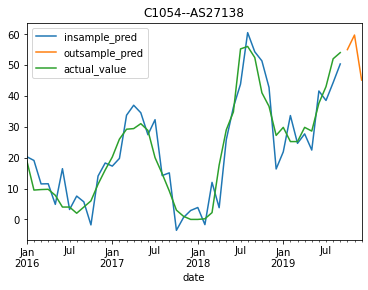

C1054
AS42018
C1059
AS27138
(1, 0, 0)
(0, 0, 0, 12)


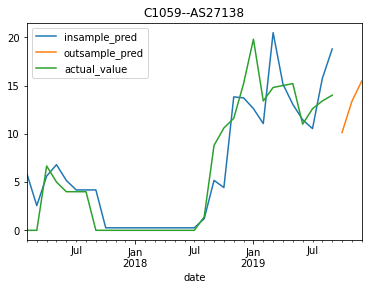

C1059
AS42018
(0, 0, 0)
(0, 0, 0, 0)
error


In [9]:
%run model_SARIMAX_individual_rollingsmoothed.ipynb

     - input: 
        - '../0_data/df_combined_fullsample.csv'
     - output: 
        - '../2_pipeline/final_pred_ind_rollingsmoothed_lev.csv' 

        
        
## Step 3: Ensemble, learn the ensemble model, make final prediction 
- notebook: ensemble.ipynb 


 importing results from the distribution stage of various aggregation levels 

['../2_pipeline\\final_distribute_districtlev.csv', '../2_pipeline\\final_distribute_regionlev.csv', '../2_pipeline\\final_distribute_regionproducttypelev.csv']
Import SARIMAX_agg model results and merge with predicted distribute values

 Import three individual level sarimax results 

['../2_pipeline\\final_pred_ind_lev.csv', '../2_pipeline\\final_pred_ind_rollingsmoothed_lev.csv', '../2_pipeline\\final_pred_ind_winsorized_lev.csv']


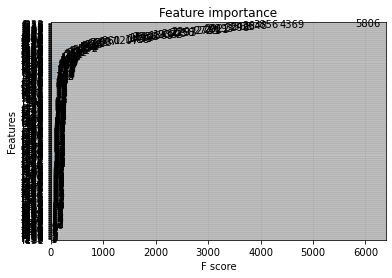

In [11]:
%run ensemble.ipynb 

    - input: 
        - Distribution model results: glob.glob('../2_pipeline/final_distribute_*.csv') 
        - SARIMAX results: glob.glob('../2_pipeline/final_pred_ind*.csv') 
    - output: 
        - submission.csv
 